<a href="https://colab.research.google.com/github/AisIzmailova/AisIzmailova_Practice_Notebooks/blob/master/DL_Transfer_Learning_with_Tensorflow_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning

##Part 3: Scaling Up

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
import pathlib
import numpy as np
import random
import datetime

In [ ]:
#Get data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-12-27 02:31:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 142.250.107.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  74.1MB/s    in 22s     

2023-12-27 02:31:48 (71.6 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
#Unzip the data
filename="101_food_classes_10_percent.zip"
zip_ref = zipfile.ZipFile(filename, "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
#Define directories
train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

In [ ]:

IMAGE_SIZE=(224,224)
BATCH_SIZE=32
#Define train and test data
train_data_101_class_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                      label_mode="categorical",
                                                                                      image_size=IMAGE_SIZE,
                                                                                      batch_size=BATCH_SIZE)
test_data_101_class_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                                     label_mode="categorical",
                                                                                     image_size=IMAGE_SIZE,
                                                                                     batch_size=BATCH_SIZE,
                                                                                     shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##Train the model on 101 food classes

1. Create a model checkpoint callback
2. Create data augmentation layer
3. Build headless (no top layer) functional efficientnet model
4. Compile the model
5. Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of test data)

In [ ]:
#1.Create model checkpoint callback
checkpoint_path = "101_classes_10_percent_checkpoint.ckpt"

In [ ]:
def create_model_checkpoint_callback(filepath):
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                             save_weights_only=True,
                                                             save_best_only=True,
                                                             monitor="val_accuracy",
                                                             save_freq="epoch",
                                                             verbose=1)
    return checkpoint_callback

In [ ]:
#2.Create data augmentation layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation=keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")


In [ ]:
#3.Build model from functional api
input_shape=IMAGE_SIZE+(3,)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False
inputs=layers.Input(shape=input_shape)
x=data_augmentation(inputs)
x=base_model(x, training=False)
x=layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs=layers.Dense(len(train_data_101_class_10_percent.class_names), activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)

In [ ]:
#4.Compile the model
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
#5.Fit the model
history=model.fit(train_data_101_class_10_percent,
                  epochs=5,
                  validation_data=test_data_101_class_10_percent,
                  validation_steps=int(0.15*len(test_data_101_class_10_percent)),
                  callbacks=create_model_checkpoint_callback(checkpoint_path))


Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.5110 - accuracy: 0.2418
Epoch 1: val_accuracy improved from -inf to 0.37209, saving model to 101_classes_10_percent_checkpoint.ckpt
237/237 [==============================] - 84s 319ms/step - loss: 3.5110 - accuracy: 0.2418 - val_loss: 2.7793 - val_accuracy: 0.3721
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.4144 - accuracy: 0.4535
Epoch 2: val_accuracy improved from 0.37209 to 0.45445, saving model to 101_classes_10_percent_checkpoint.ckpt
237/237 [==============================] - 69s 291ms/step - loss: 2.4144 - accuracy: 0.4535 - val_loss: 2.2669 - val_accuracy: 0.4544
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0383 - accuracy: 0.5180
Epoch 3: val_accuracy improved from 0.45445 to 0.47405, saving model to 101_classes_10_percent_checkpoint.ckpt
237/237 [==============================] - 64s 268ms/step - loss: 2.0383 - accuracy: 0.5180 - val_loss: 2.1127 - val_

In [ ]:
#6.Evaluate the model
results_model=model.evaluate(test_data_101_class_10_percent)
print(results_model)

790/790 [==============================] - 53s 68ms/step - loss: 1.6267 - accuracy: 0.5731
[1.6267085075378418, 0.5731089115142822]


##Fine tune the model

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-5]:
    layer.trainable=False

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [ ]:
#Compile the model
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

#Fit the model
history_fine_tuned=model.fit(train_data_101_class_10_percent,
                  epochs=10,
                  validation_data=test_data_101_class_10_percent,
                  validation_steps=int(0.15*len(test_data_101_class_10_percent)),
                  initial_epoch=history.epoch[-1],
                  callbacks=create_tensorboard_callback("transfer_learning",
                                                        experiment_name="101_classes_10_percent"))

Saving TensorBoard log files to: transfer_learning/101_classes_10_percent/20231227-023936
Epoch 5/10
237/237 [==============================] - 68s 247ms/step - loss: 1.4749 - accuracy: 0.6259 - val_loss: 1.8620 - val_accuracy: 0.5146
Epoch 6/10
237/237 [==============================] - 53s 220ms/step - loss: 1.3827 - accuracy: 0.6412 - val_loss: 1.8404 - val_accuracy: 0.5204
Epoch 7/10
237/237 [==============================] - 50s 211ms/step - loss: 1.3280 - accuracy: 0.6498 - val_loss: 1.8399 - val_accuracy: 0.5188
Epoch 8/10
237/237 [==============================] - 49s 204ms/step - loss: 1.2933 - accuracy: 0.6561 - val_loss: 1.7964 - val_accuracy: 0.5297
Epoch 9/10
237/237 [==============================] - 49s 205ms/step - loss: 1.2423 - accuracy: 0.6723 - val_loss: 1.8245 - val_accuracy: 0.5265
Epoch 10/10
237/237 [==============================] - 43s 181ms/step - loss: 1.2108 - accuracy: 0.6813 - val_loss: 1.8328 - val_accuracy: 0.5270


In [ ]:
results_fine_tuned_model=model.evaluate(test_data_101_class_10_percent)

790/790 [==============================] - 55s 69ms/step - loss: 1.4912 - accuracy: 0.6012


In [ ]:
print("Fine Tuned Model Evaluation ", results_fine_tuned_model)

Fine Tuned Model Evaluation  [1.4911621809005737, 0.6011881232261658]


In [ ]:
def compare_histories(original_history,new_history, initial_epochs=5):
    """
    Compares two tensorflow history objects
    """
    #Get original_history metrics
    acc=original_history.history["accuracy"]
    loss=original_history.history["loss"]
    val_acc=original_history.history["val_accuracy"]
    val_loss=original_history.history["val_loss"]
    #Combine original hisotry metrics with new_history metrics
    total_acc=acc+new_history.history["accuracy"]
    total_loss=loss+new_history.history["loss"]
    total_val_acc=val_acc+new_history.history["val_accuracy"]
    total_val_loss=val_loss+new_history.history["val_loss"]
    #Plot accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc='lower right')
    plt.title("Training and Validation Loss")

    # Plot loss
    #plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning")
    plt.legend(loc='upper right')
    plt.title("Training and Validation Loss")

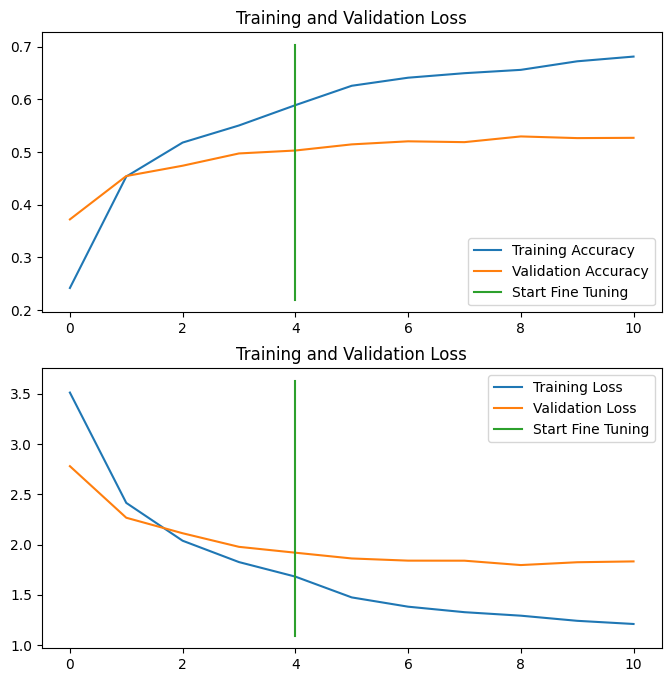

In [ ]:
compare_histories(history, history_fine_tuned, initial_epochs=5)

In [ ]:
#Save our model
model.save("fined_tuned_model")

In [ ]:
#Load the model
loaded_model=tf.keras.models.load_model("fined_tuned_model")

##Load Pretrained Model

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip"
zip_ref = zipfile.ZipFile("06_101_food_class_10_percent_saved_big_dog_model.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-27 02:57:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 173.194.202.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   142MB/s    in 0.3s    

2023-12-27 02:57:52 (142 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
#Download pretrained model
model_retrieved=tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

results_retrieved_model=model_retrieved.evaluate(test_data_101_class_10_percent)
print(results_retrieved_model)

790/790 [==============================] - 61s 72ms/step - loss: 1.8027 - accuracy: 0.6078
[1.8027204275131226, 0.6077623963356018]


##Evaluate the model

In [ ]:
#Making predictions with our model
preds_probs= model_retrieved.predict(test_data_101_class_10_percent, verbose=1)
print(f"The shape of preds_probs is: {preds_probs.shape} and the length is {len(preds_probs)}")
class_names=train_data_101_class_10_percent.class_names
print(class_names)
print(tf.argmax(preds_probs[0]))
class_names[tf.argmax(preds_probs[0])]

790/790 [==============================] - 69s 86ms/step
The shape of preds_probs is: (25250, 101) and the length is 25250
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros'

'gyoza'

In [ ]:
pred_classes=preds_probs.argmax(axis=1)
print(pred_classes[:10])

[52  0  0 80 79 61 29  0 85  0]


Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original dataset labels.

In [ ]:
#To get our test labels we need to unravel our test_data batchdataset
y_labels=[]
for images, labels in test_data_101_class_10_percent.unbatch():
    y_labels.append(labels.numpy().argmax())
print(y_labels[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
print("Sklearn accuracy ", sklearn_accuracy)

Sklearn accuracy  0.6077623762376237


In [ ]:
import numpy as np
print(np.isclose(results_retrieved_model[1], sklearn_accuracy))

True


In [ ]:
#Draw confusion matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    import itertools
    from sklearn.metrics import confusion_matrix
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [ ]:
class_names=train_data_101_class_10_percent.class_names
make_confusion_matrix(y_labels, pred_classes, class_names, figsize=(100,100), text_size=10, savefig=True)

##Evaluate the model using other metrics

Scikit-learn has a helpful function for acquiring many different classification metrics per class called classification report.
Classification report gives a great class-by-class evaluation of our model's predictions.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
#Visualize the classification report
classification_report_dict=classification_report(y_labels, pred_classes, output_dict=True)

In [ ]:
#Plot all classes' F1-score

#Create empty dictionary
class_f1_scores={}
#Loop through classification report dictionary items
for k,v in classification_report_dict.items():
    if k=="accuracy":
        break
    else:
        #Add class names and f1-scores to out dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
print(class_f1_scores)

{'apple_pie': 0.24056603773584903, 'baby_back_ribs': 0.5864406779661017, 'baklava': 0.6022304832713754, 'beef_carpaccio': 0.616822429906542, 'beef_tartare': 0.544080604534005, 'beet_salad': 0.41860465116279066, 'beignets': 0.7229357798165138, 'bibimbap': 0.7908902691511386, 'bread_pudding': 0.3866943866943867, 'breakfast_burrito': 0.5117370892018779, 'bruschetta': 0.5047619047619047, 'caesar_salad': 0.6161616161616161, 'cannoli': 0.6105610561056106, 'caprese_salad': 0.5775193798449612, 'carrot_cake': 0.574757281553398, 'ceviche': 0.36744186046511623, 'cheese_plate': 0.5654135338345864, 'cheesecake': 0.42546063651591287, 'chicken_curry': 0.5008403361344538, 'chicken_quesadilla': 0.6411889596602972, 'chicken_wings': 0.7123809523809523, 'chocolate_cake': 0.45261669024045265, 'chocolate_mousse': 0.3291592128801431, 'churros': 0.7134935304990757, 'clam_chowder': 0.7708779443254817, 'club_sandwich': 0.734020618556701, 'crab_cakes': 0.4625550660792952, 'creme_brulee': 0.7494824016563146, 'cro

In [ ]:
#Turn f1-scores into dataframe
import pandas as pd
f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)

f1_scores.head()

,class_names,f1_score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008


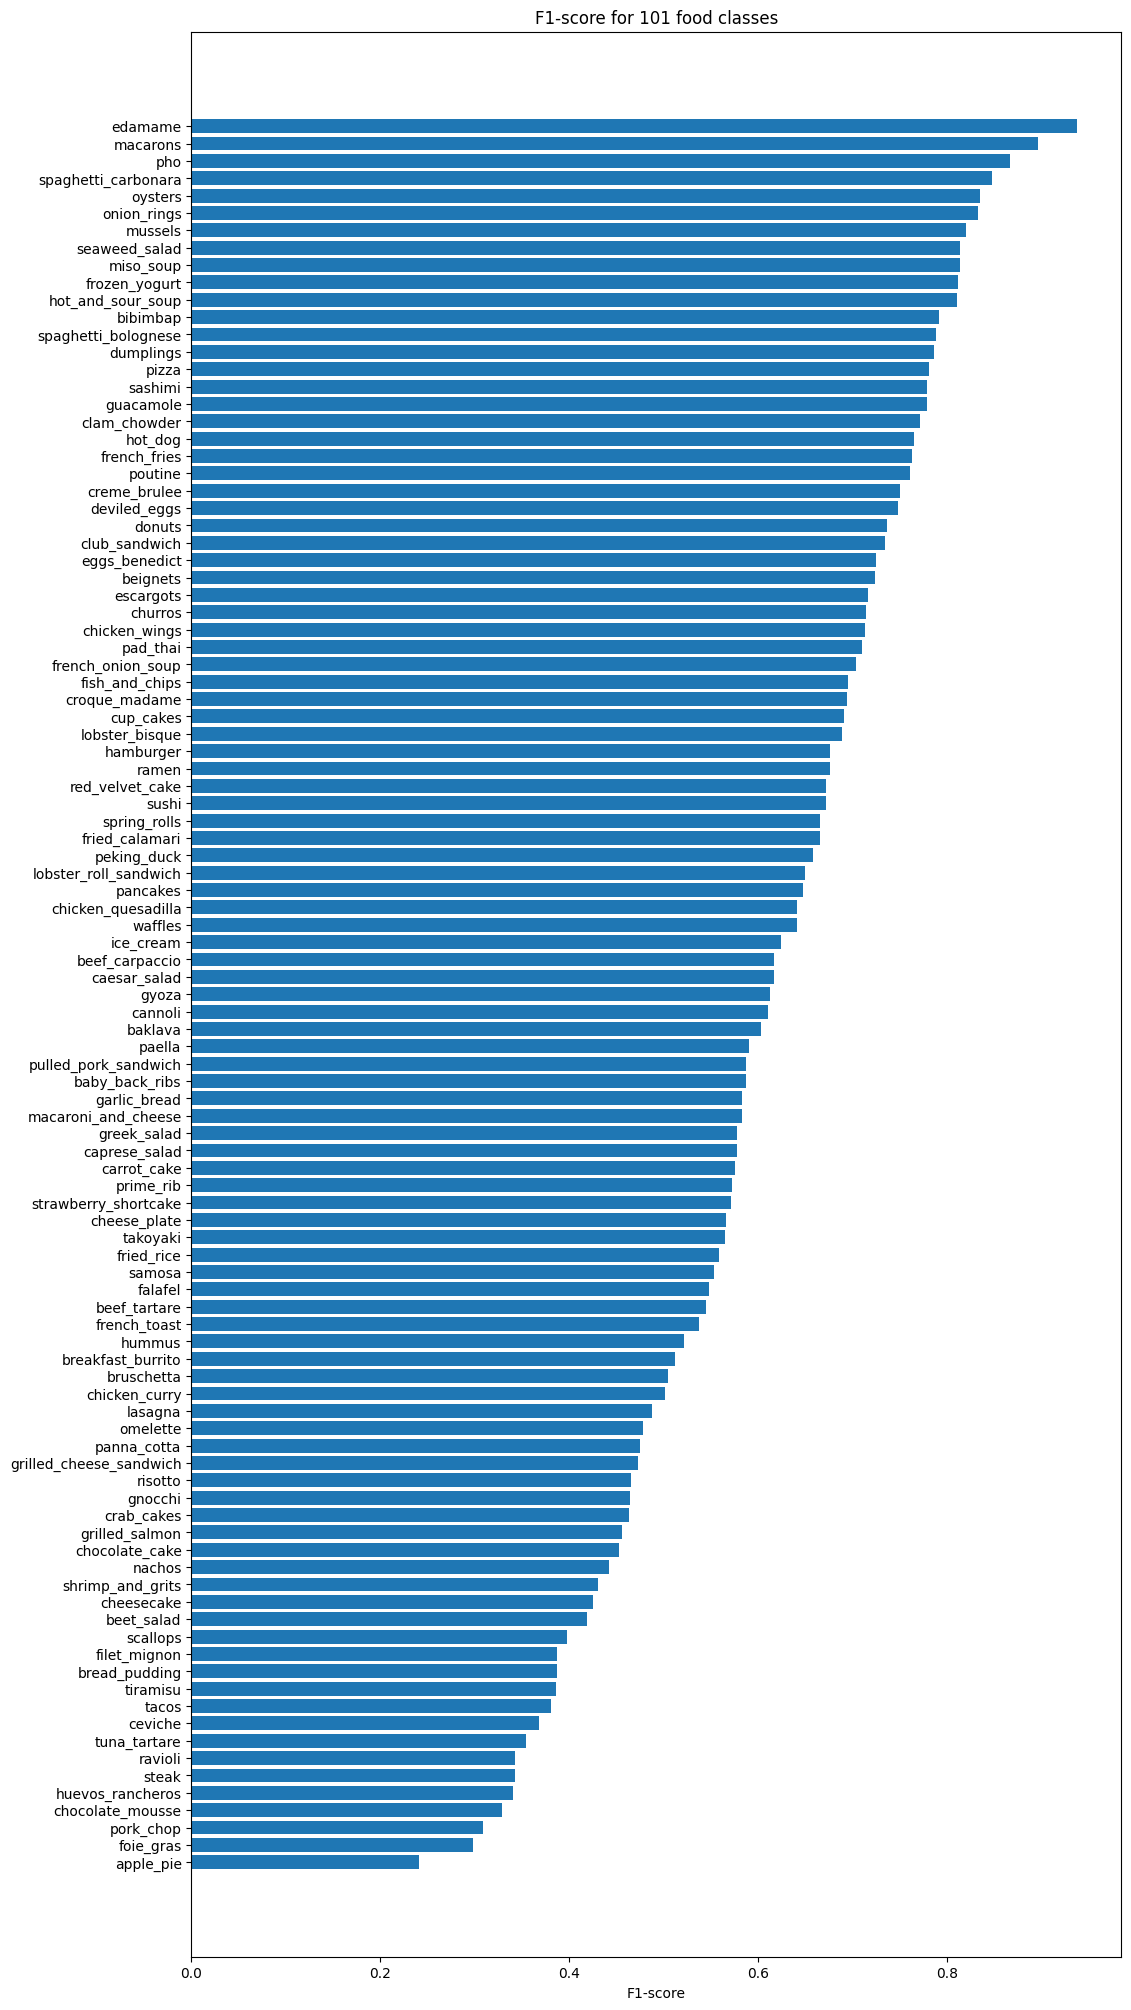

In [ ]:
#Plot bar chart
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 food classes")
ax.invert_yaxis() #reverse the order of our plot

##Visualize predictions on test images

To visualize our model's predictions on our own images, we will need to load and preprocess images,
specifically will need to:
1. Read a target image using tf.io.read_file()
2. Turn image into a Tensor using tf.io.decode_image()
3. Resize the image tensor to be the same size as the images our model has been trained on
4. Scale the image to get all of the pixel values btwn 0 and 1

In [ ]:
def load_and_prep_image(filename,img_shape=224, scale=True):
    """
    Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels).
    """
    #Read the image
    img = tf.io.read_file(filename)
    #Decode the read file into a tensor
    img = tf.image.decode_image(img, channels=3)
    #Resize the image
    img = tf.image.resize(img, size=[img_shape, img_shape])
    #Rescale the image (get all values btwn 0 and 1)
    if scale:
        img=img/255.
    else:
      img
    return img

In [ ]:
def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes prediction with the model and plots the image with the predicted class the title.
    """
    #Import the target image and preprocess it
    img = load_and_prep_image(filename)

    #Make prediction
    pred_prob=model.predict(tf.expand_dims(img, axis=0))
    print(pred_prob[0])
    print(tf.argmax(pred_prob[0]))
    print(class_names[tf.argmax(pred_prob[0])])
    #Add logic for multiclass classification
    if len(pred_prob[0])>1:
        pred_class=class_names[pred_prob.argmax()]
    else:
        #Get the predicted class for binary classification
        pred_class = class_names[int(tf.round(pred))]

    #Plot the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"{pred_class}")
    plt.axis(False)

crab_cakes
1/1 [==============================] - 3s 3s/step
[0.00964525 0.01324361 0.02714214 0.01267874 0.0119348  0.01116288
 0.01003035 0.00691154 0.01856989 0.00375592 0.00584796 0.00193211
 0.00119256 0.01078493 0.00839313 0.00355506 0.00854431 0.01425659
 0.00308261 0.01496228 0.0142705  0.00458195 0.00189298 0.00662158
 0.01005262 0.00346581 0.0031682  0.01194195 0.0019293  0.00374366
 0.05083279 0.00310019 0.00591402 0.03076497 0.0005718  0.0016469
 0.00363098 0.00175475 0.00496507 0.00585815 0.03083185 0.01607956
 0.00130406 0.02811428 0.02331902 0.00337904 0.00388424 0.00180324
 0.00646389 0.00281471 0.00185807 0.01153595 0.00806074 0.00359421
 0.08671235 0.00177005 0.00301138 0.0038859  0.00695308 0.00683701
 0.02450146 0.00353592 0.067422   0.00614862 0.02550396 0.00168564
 0.016249   0.00071267 0.00886392 0.00249362 0.00159047 0.01266866
 0.00074513 0.00641966 0.00163194 0.01101684 0.01976461 0.00180383
 0.0070226  0.00247076 0.00078913 0.00899785 0.00371865 0.01336748
 0

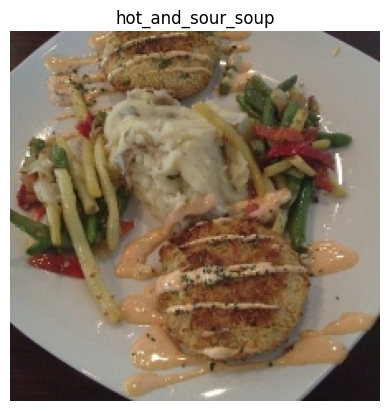

In [ ]:
import random
class_names=train_data_101_class_10_percent.class_names
target_dir="101_food_classes_10_percent/train/"
target_class = random.choice(os.listdir(target_dir))
print(target_class)
target_image = random.choice(os.listdir(target_dir + target_class))
img_path = target_dir + target_class + "/" + target_image
# img=load_and_prep_image(img_path)
# pred_prob=loaded_model.predict(tf.expand_dims(img, axis=0))
# print(pred_prob[0])
# print(pred_prob.argmax())
# pred_class=class_names[pred_prob.argmax()]
# print(f"Predicted food class {pred_class}, actual food class {target_class}")
pred_and_plot(loaded_model, img_path, class_names)

##Finding the most wrong predictions

To find out where our model us most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method
2. Create pandas dataframe of the image filepaths, ground truth labels, predicted classes, max prediction probabilities.
3. Use our dataframe to find all the wrong predictions.
4. Sort the dataframe based on wrong predictions (have highest prediction probabilities at the top).
5. Visualize the images with highest prediction probabilities but have the wrong prediction.

In [ ]:
#1.Get all the image filepaths
filepaths=[]
for filepath in test_data_101_class_10_percent.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
print(filepaths[:10])

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg', b'101_food_classes_10_percent/test/apple_pie/101251.jpg', b'101_food_classes_10_percent/test/apple_pie/1034399.jpg', b'101_food_classes_10_percent/test/apple_pie/103801.jpg', b'101_food_classes_10_percent/test/apple_pie/1038694.jpg', b'101_food_classes_10_percent/test/apple_pie/1047447.jpg', b'101_food_classes_10_percent/test/apple_pie/1068632.jpg', b'101_food_classes_10_percent/test/apple_pie/110043.jpg', b'101_food_classes_10_percent/test/apple_pie/1106961.jpg', b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']


In [ ]:
#2.Create DataFrame
pred_df=pd.DataFrame({"img_path": filepaths,
                      "y_true": y_labels,
                      "y_pred": pred_classes,
                      "pred_conf": preds_probs.max(axis=1),#get the max prediction probability value
                      "y_true_classname": [class_names[i] for i in y_labels],
                      "y_pred_classname": [class_names[i] for i in pred_classes]
                      })

In [ ]:
#3.Find all the wrong predictions
pred_df["pred_correct"]=pred_df["y_true"]==pred_df["y_pred"]
print(pred_df.head())

                                            img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False  


In [ ]:
#4.Sort the dataframe
top_100_wrong=pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf", ascending=False)[:100]
print(top_100_wrong.head(20))

                                                img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101

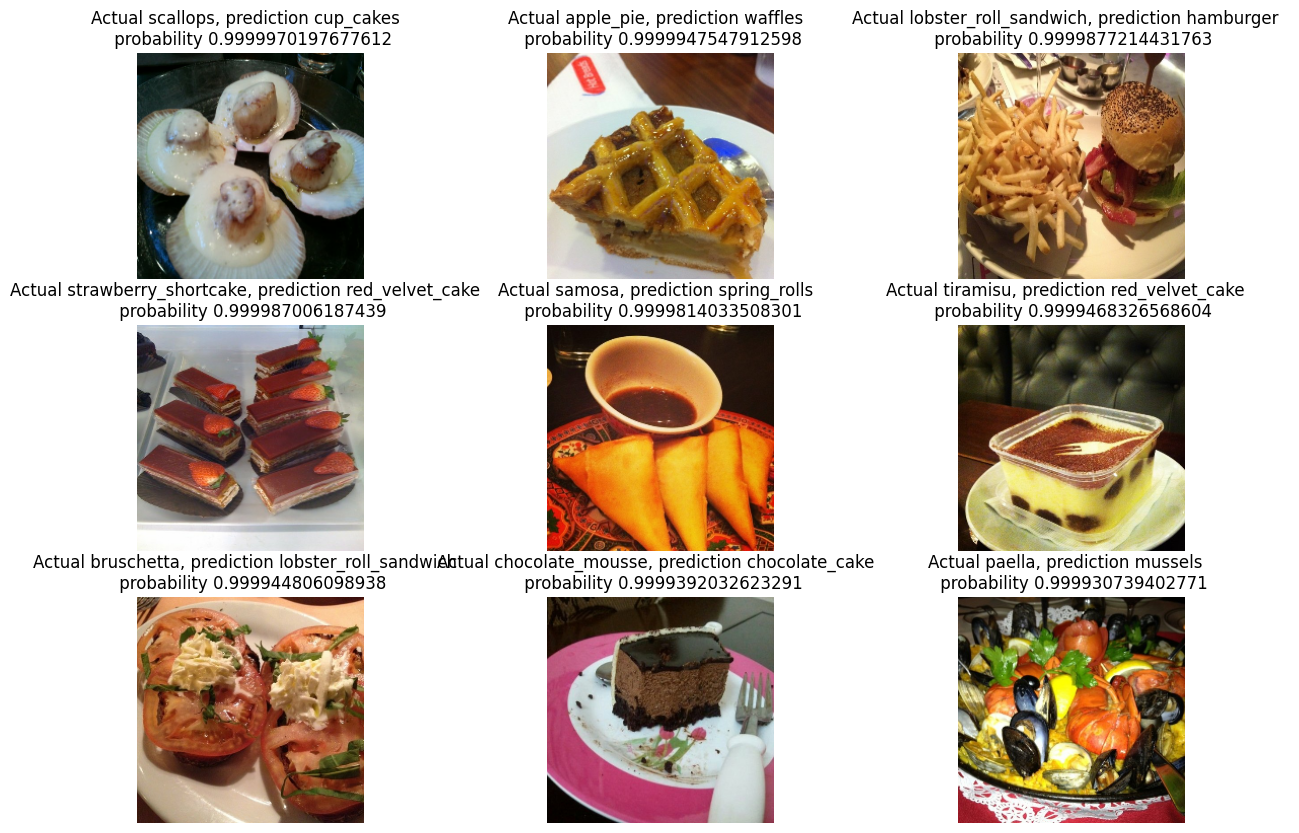

In [ ]:
#5.Visualize
images_to_view=9
start_index=0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img=load_and_prep_image(row[1])
    _,_,_,_,pred_conf, y_true_classname, y_pred_classname, _= row# only interested in few values from the row
    plt.imshow(img)
    plt.title(f"Actual {y_true_classname}, prediction {y_pred_classname}  \n probability {pred_conf}")
    plt.axis(False)